# Tutorial: Data on Manifolds

## Setup

Before starting this tutorial, we set the working directory to be the root of the geomstats repository. In order to have the code working on your machine, you need to change this path to the path of your geomstats repository.

In [1]:
import os
import subprocess

geomstats_gitroot_path = subprocess.check_output(
    ['git', 'rev-parse', '--show-toplevel'], 
    universal_newlines=True)

os.chdir(geomstats_gitroot_path[:-1])

print('Working directory: ', os.getcwd())

Working directory:  /Users/ninamiolane/code/geomstats


We import the backend that will be used for geomstats computations and set a seed for reproducibility of the results.

In [2]:
import sys
import geomstats.backend as gs

gs.random.seed(2020)

INFO: Using numpy backend


Finally, we import the visualization module.

In [3]:
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


import geomstats.visualization as visualization

visualization.tutorial_matplotlib()

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


### Hands shapes

Load the dataset of hand poses, where a hand is represented as a 
set of 22 landmarks - the hands joints - in 3D.

The hand poses represent two different hand poses:
- Label 0: hand is in the position "Grab"
- Label 1: hand is in the position "Expand"

This is a subset of the SHREC 2017 dataset (SWVGLF2017).

##### Reference
(SWVGLF2017) Q. De Smedt, H. Wannous, J.P. Vandeborre, 
J. Guerry, B. Le Saux, D. Filliat, SHREC'17 Track: 3D Hand Gesture 
Recognition Using a Depth and Skeletal Dataset, 10th Eurographics 
Workshop on 3D Object Retrieval, 2017.
https://doi.org/10.2312/3dor.20171049


We load the dataset of landmarks' sets and corresponding labels.

In [73]:
import geomstats.datasets.utils as data_utils

hands, labels, bone_list = data_utils.load_hands()

In [75]:
hands.shape

(52, 22, 3)

We extract two hands, one corresponding to the "Grab" pose, and the other to the "Expand" pose.

In [67]:
label_to_str = {0: 'Grab', 1: 'Expand'}
first_grab_hand = hands_shape[labels==0][0]
first_expand_hand = hands_shape[labels==1][0]

We implement a function to plot one hand in 3D.

In [68]:
def plot_hand(hand, label, bone_list):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    plt.title(f"Hand: {label_to_str[label]}")

    x = hand[:, 0]
    y = hand[:, 1]
    z = hand[:, 2]

    sc = ax.scatter(x, y, z, s=40)
    for bone in bone_list:
        start_bone_idx = bone[0]
        end_bone_idx = bone[1]
        ax.plot(
            xs=[x[start_bone_idx], x[end_bone_idx]],
            ys=[y[start_bone_idx], y[end_bone_idx]],
            zs=[z[start_bone_idx], z[end_bone_idx]],
        )

    plt.show()
    

We plot two examples of hands.

<IPython.core.display.Javascript object>


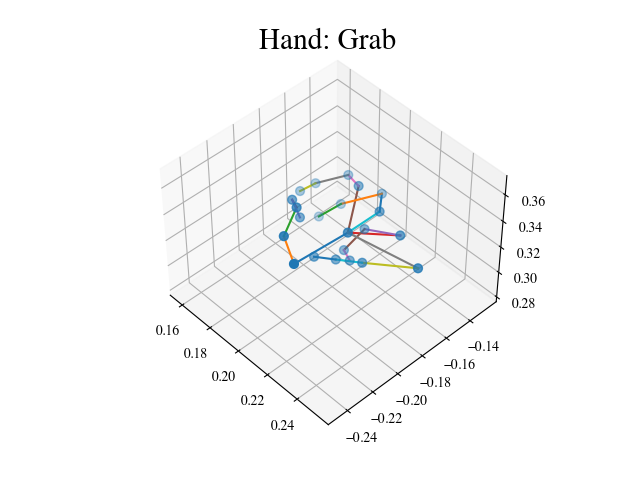

<IPython.core.display.Javascript object>


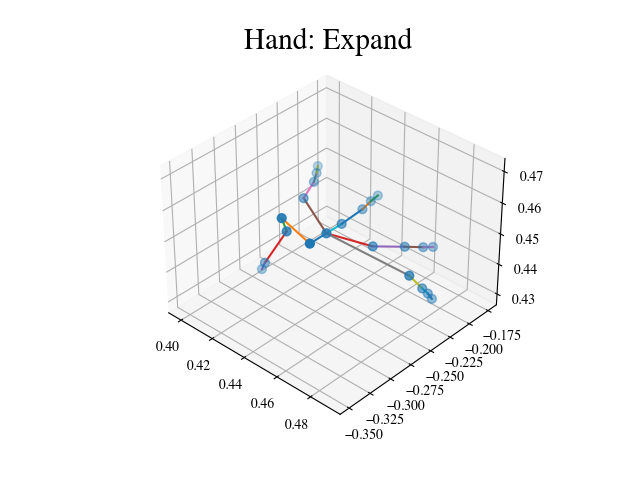

In [71]:
%matplotlib notebook


plot_hand(first_grab_hand, 0, bone_list)
plot_hand(first_expand_hand, 1, bone_list)